In [2]:
import gzip
import pickle
import numpy as np
import pandas as pd

In [3]:
with gzip.open('df_01.pickle','rb') as f:
    df01 = pickle.load(f)

In [4]:
with gzip.open('df_02.pickle','rb') as f:
    df02 = pickle.load(f)

In [9]:
with open('item2idx.pickle', 'rb') as f:
    item2idx = pickle.load(f)

In [5]:
df = pd.concat([df01, df02])
del df01, df02
df.shape

(46296, 8)

# Basic Model [train 1~5, predict 6th basket]

In [6]:
# split into train and test sets
train = df[df.order_cnt <= 1]
test = df[df.order_cnt ==2]
print(train.shape, test.shape)

(7716, 8) (7716, 8)


In [7]:
x_train = train.drop(['order_id', 'output'], axis=1).set_index('user_id')
y_train = train[[ 'output']]
X_train=x_train.values
Y_train=y_train.values
print('X_train', X_train.shape, 'Y_train', Y_train.shape)
print('X_train[0]', X_train[0].shape)

X_train (7716, 5) Y_train (7716, 1)
X_train[0] (5,)


In [10]:
X_train_array = []
N_total_train_session = X_train.shape[0]
for j in range(N_total_train_session):
    for i in range(4): #n_step size 
        X_train_array.append(np.asarray(X_train[j][i]))
        
X_train_array = np.array(X_train_array)
X_train_array = X_train_array.reshape(N_total_train_session, 4, len(item2idx))
print('학습X', X_train_array.shape)

Y_train_array = []
for i in range(N_total_train_session):
    Y_train_array.append(np.asarray(Y_train[i][0]))

Y_train_array=np.array(Y_train_array)
print('학습Y',  Y_train_array.shape)

학습X (7716, 4, 9073)
학습Y (7716, 9073)


In [12]:
#실험 Y 
test_y  = test[['user_id','output']]
test_y.head(3)

,user_id,output
1,76,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,131,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.utils import np_utils
import keras.backend as K 
from keras.optimizers import SGD

Using TensorFlow backend.


# Optimizer 비교 - default structure only

In [14]:
K.clear_session()

my_opt_sgd = SGD(lr=0.1)

model_LSTM_100_OPT01 = Sequential()
model_LSTM_100_OPT01.add(LSTM(100, input_shape = (4, len(item2idx)))) #input_shape=(timesteps, data_dim)
model_LSTM_100_OPT01.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT01.summary()
model_LSTM_100_OPT01.compile(loss='categorical_crossentropy', optimizer=my_opt_sgd, metrics=['categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________


In [79]:
history_LSTM_100_OPT01 = model_LSTM_100_OPT01.fit(X_train_array, Y_train_array, epochs=50, batch_size=20, verbose=2)

Epoch 1/50
 - 9s - loss: 74.2871 - categorical_accuracy: 0.0080
Epoch 2/50
 - 8s - loss: 69.5880 - categorical_accuracy: 0.0039
Epoch 3/50
 - 8s - loss: 68.9796 - categorical_accuracy: 0.0038
Epoch 4/50
 - 8s - loss: 68.6724 - categorical_accuracy: 0.0031
Epoch 5/50
 - 8s - loss: 68.3287 - categorical_accuracy: 0.0054
Epoch 6/50
 - 8s - loss: 67.5509 - categorical_accuracy: 0.0089
Epoch 7/50
 - 8s - loss: 66.8032 - categorical_accuracy: 0.0114
Epoch 8/50
 - 8s - loss: 66.1384 - categorical_accuracy: 0.0136
Epoch 9/50
 - 8s - loss: 65.3649 - categorical_accuracy: 0.0227
Epoch 10/50
 - 8s - loss: 64.4350 - categorical_accuracy: 0.0302
Epoch 11/50
 - 8s - loss: 63.4056 - categorical_accuracy: 0.0358
Epoch 12/50
 - 8s - loss: 62.2992 - categorical_accuracy: 0.0428
Epoch 13/50
 - 8s - loss: 61.1040 - categorical_accuracy: 0.0500
Epoch 14/50
 - 8s - loss: 59.8559 - categorical_accuracy: 0.0557
Epoch 15/50
 - 8s - loss: 58.5367 - categorical_accuracy: 0.0642
Epoch 16/50
 - 8s - loss: 57.2138 

In [80]:
model_LSTM_100_OPT01.save('181024_model_LSTM_100h_OPT01_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT01.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT01.history, handle)

In [16]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT01.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT01 = load(handle)

In [82]:
K.clear_session()

from keras import optimizers 
momentum = optimizers.SGD(lr=0.1, momentum=0.9)

model_LSTM_100_OPT02 = Sequential()
model_LSTM_100_OPT02.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT02.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT02.summary()
model_LSTM_100_OPT02.compile(loss='categorical_crossentropy', optimizer=momentum, metrics=['categorical_accuracy'])
history_LSTM_100_OPT02 =model_LSTM_100_OPT02.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               3669600   
_________________________________________________________________
dense_1 (Dense)              (None, 9073)              916373    
Total params: 4,585,973
Trainable params: 4,585,973
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 10s - loss: 70.4666 - categorical_accuracy: 0.0041
Epoch 2/50
 - 10s - loss: 66.9467 - categorical_accuracy: 0.0163
Epoch 3/50
 - 10s - loss: 64.3533 - categorical_accuracy: 0.0351
Epoch 4/50
 - 10s - loss: 61.4376 - categorical_accuracy: 0.0461
Epoch 5/50
 - 10s - loss: 58.0966 - categorical_accuracy: 0.0592
Epoch 6/50
 - 10s - loss: 54.2965 - categorical_accuracy: 0.0697
Epoch 7/50
 - 10s - loss: 50.2233 - categorical_accuracy: 0.0837
Epoch 8/50
 - 10s - loss: 45.9923 - categorical_accuracy: 0.1024
Epoch 9/

In [83]:
model_LSTM_100_OPT02.save('181024_model_LSTM_100h_OPT02_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT02.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT02.history, handle)

In [17]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT02.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT02 = load(handle)

In [ ]:
K.clear_session()

nag = optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True)

model_LSTM_100_OPT03 = Sequential()
model_LSTM_100_OPT03.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT03.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT03.summary()
model_LSTM_100_OPT03.compile(loss='categorical_crossentropy', optimizer=nag, metrics=['categorical_accuracy'])
history_LSTM_100_OPT03 =model_LSTM_100_OPT03.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

In [86]:
model_LSTM_100_OPT03.save('181024_model_LSTM_100h_OPT03_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT03.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT03.history, handle)

In [18]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT03.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT03 = load(handle)

In [ ]:
K.clear_session()

adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-6)

model_LSTM_100_OPT04 = Sequential()
model_LSTM_100_OPT04.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT04.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT04.summary()
model_LSTM_100_OPT04.compile(loss='categorical_crossentropy', optimizer=adagrad, metrics=['categorical_accuracy'])
history_LSTM_100_OPT04 =model_LSTM_100_OPT04.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

In [89]:
model_LSTM_100_OPT04.save('181024_model_LSTM_100h_OPT04_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT04.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT04.history, handle)

In [19]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT04.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT04 = load(handle)

In [ ]:
K.clear_session()

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model_LSTM_100_OPT05 = Sequential()
model_LSTM_100_OPT05.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT05.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT05.summary()
model_LSTM_100_OPT05.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['categorical_accuracy'])
history_LSTM_100_OPT05 =model_LSTM_100_OPT05.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

In [92]:
model_LSTM_100_OPT05.save('181024_model_LSTM_100h_OPT05_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT05.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT05.history, handle)

In [20]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT05.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT05 = load(handle)

In [ ]:
K.clear_session()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                      epsilon=None, decay=0.0, amsgrad=False)

model_LSTM_100_OPT06 = Sequential()
model_LSTM_100_OPT06.add(LSTM(100, input_shape = (4, len(item2idx))))
model_LSTM_100_OPT06.add(Dense(len(item2idx), activation='softmax'))
model_LSTM_100_OPT06.summary()
model_LSTM_100_OPT06.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
history_LSTM_100_OPT06 =model_LSTM_100_OPT06.fit(X_train_array, Y_train_array,  epochs=50,  batch_size=20, verbose=2)

In [95]:
model_LSTM_100_OPT06.save('181024_model_LSTM_100h_OPT06_50e.h5')  # creates a HDF5 file 'my_model.h5'

import pickle
with open('./history_LSTM_100_OPT06.txt', 'wb') as handle:
    pickle.dump(history_LSTM_100_OPT06.history, handle)

In [21]:
from pickle import load
import matplotlib.pyplot as plt

with open('./history_LSTM_100_OPT06.txt', 'rb') as handle: # loading old history 
    history_LSTM_100_OPT06 = load(handle)

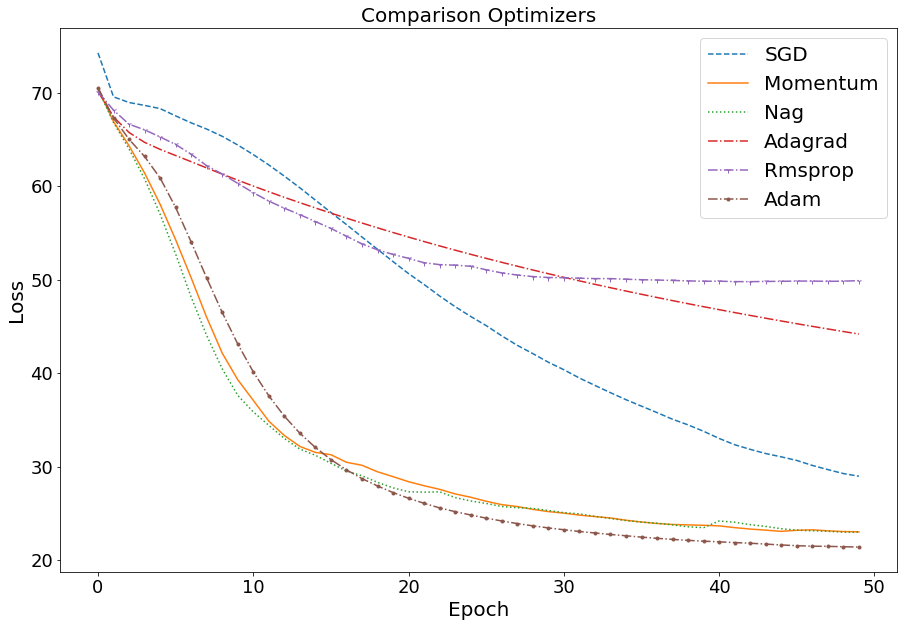

In [23]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['loss'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['loss'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['loss'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['loss'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['loss'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['loss'], linestyle= '-.', marker='.')

plt.title('Comparison Optimizers', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 20})
plt.tick_params(labelsize=18)
plt.show()

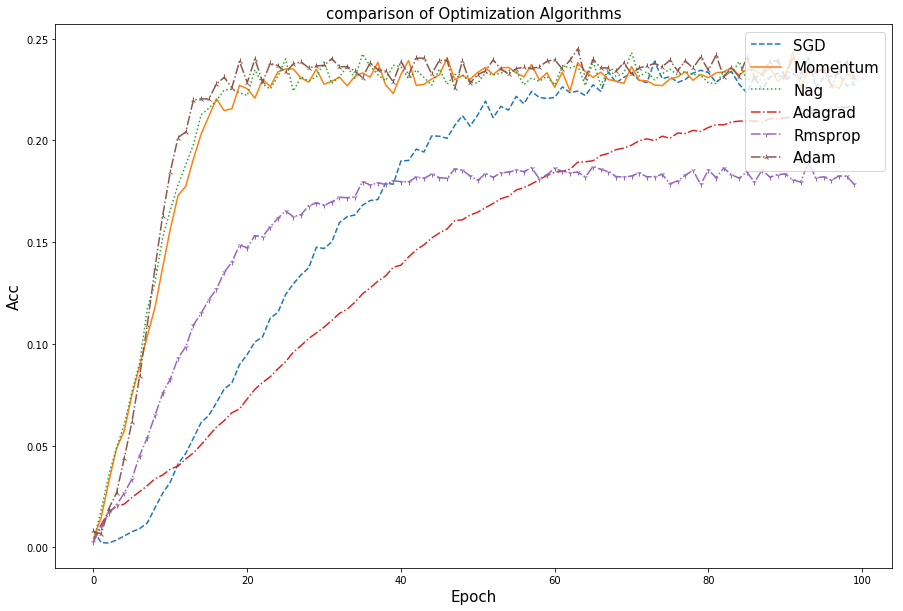

In [8]:
from matplotlib import pyplot as plt  
# summarize history for loss
plt.figure(figsize=(15,10))

plt.plot(history_LSTM_100_OPT01['categorical_accuracy'], linestyle= '--')
plt.plot(history_LSTM_100_OPT02['categorical_accuracy'], linestyle= '-')
plt.plot(history_LSTM_100_OPT03['categorical_accuracy'], linestyle= ':')
plt.plot(history_LSTM_100_OPT04['categorical_accuracy'], linestyle= '-.')
plt.plot(history_LSTM_100_OPT05['categorical_accuracy'], linestyle= '-.', marker='1')
plt.plot(history_LSTM_100_OPT06['categorical_accuracy'], linestyle= '-.', marker='2')

plt.title('comparison of Optimization Algorithms', fontsize=15)
plt.ylabel('Acc', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['SGD', 'Momentum', 'Nag', 'Adagrad','Rmsprop', 'Adam'], loc='upper right', prop={'size': 15})
plt.show()